In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import joblib


In [2]:

df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]

train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


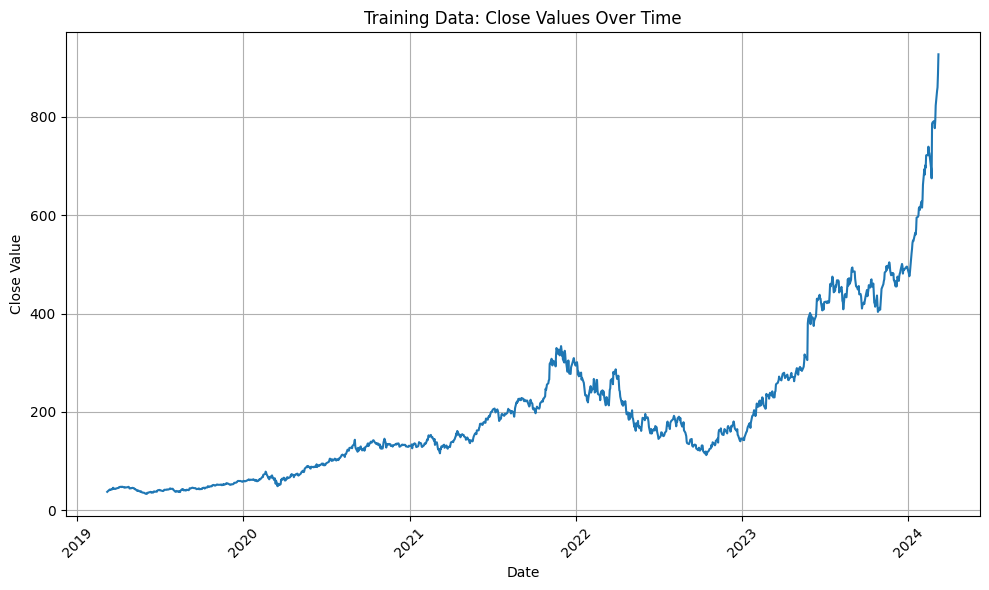

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [31]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, col_names, target_col, window_size):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[col_names].values
        X.append(values[:-1])

        target_value = window_data[target_col].values[-1]  # Extract the target column value
        y.append(target_value)
        dates.append(target_date)

        next_date = target_date + pd.tseries.offsets.BDay(1)  # Move to the next business day

        if next_date > end_date:
            break

        # Move to the next trading day
        while next_date not in dataframe.index:
            next_date += pd.tseries.offsets.BDay(1)

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i, col_name in enumerate(col_names):
        for j in range(window_size):
            ret_df[f'{col_name}-{window_size-j}'] = np.array(X)[:, j, i]
    ret_df[f'Target'] = y

    return ret_df


# # # Example usage:
# windowed_df = generate_windowed_dataset(train_df,
#                                         '2021-08-25',
#                                         '2022-08-31',
#                                         ['Close', 'Volume'],  # Example of multiple features
#                                         'Close',  # Target column
#                                         3)
# print(windowed_df)


In [32]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)


# w = prepare_dataset_for_lstm(windowed_df)[1]
# w.shape

# LSTM Baseline

## preprocessing

In [6]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'prepare_dataset_for_lstm' is not defined

## training

In [243]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

Epoch 1/100
7/7 [==============================] - 2s 50ms/step - loss: 127503.0469 - mean_absolute_error: 341.7372 - val_loss: 217585.1562 - val_mean_absolute_error: 465.5582
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 126805.5391 - mean_absolute_error: 340.7149 - val_loss: 216763.7344 - val_mean_absolute_error: 464.6752
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 126152.7812 - mean_absolute_error: 339.7357 - val_loss: 215586.4219 - val_mean_absolute_error: 463.4067
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 125205.2500 - mean_absolute_error: 338.3349 - val_loss: 214034.7031 - val_mean_absolute_error: 461.7299
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 124043.1484 - mean_absolute_error: 336.6375 - val_loss: 212413.8438 - val_mean_absolute_error: 459.9709
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 122724.6250 - mean_absolute_error: 334.6578 - val_los

## plotting

7/7 [==============================] - 0s 1ms/step


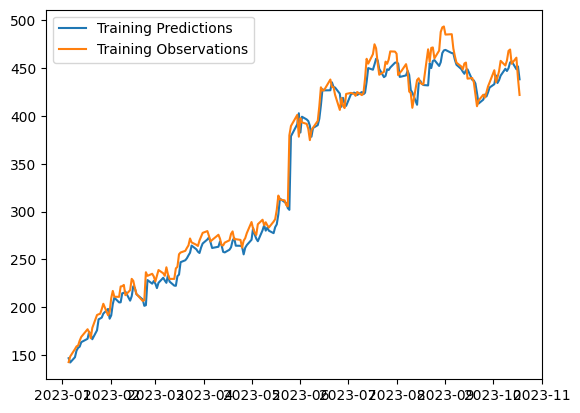

In [244]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


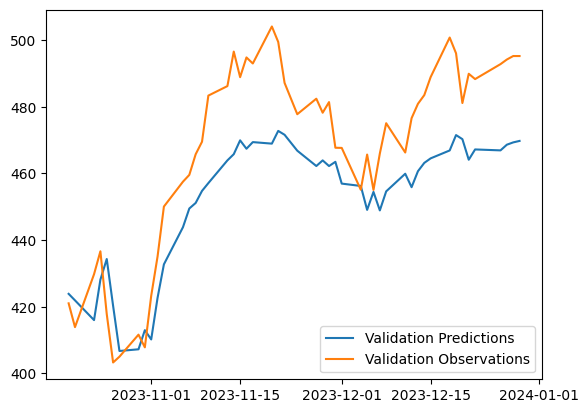

In [245]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 [==============================] - 0s 412ms/step - loss: 3607.0637 - mean_absolute_error: 58.2565
Test Loss: 3607.063720703125
Test Mean Absolute Error: 58.256526947021484
[481.679993, 475.690002, 479.980011]
deque([481.679993, 475.690002, 479.980011], maxlen=3)
[481.679993, 475.690002, 479.980011]
1/1 [==============================] - 0s 15ms/step


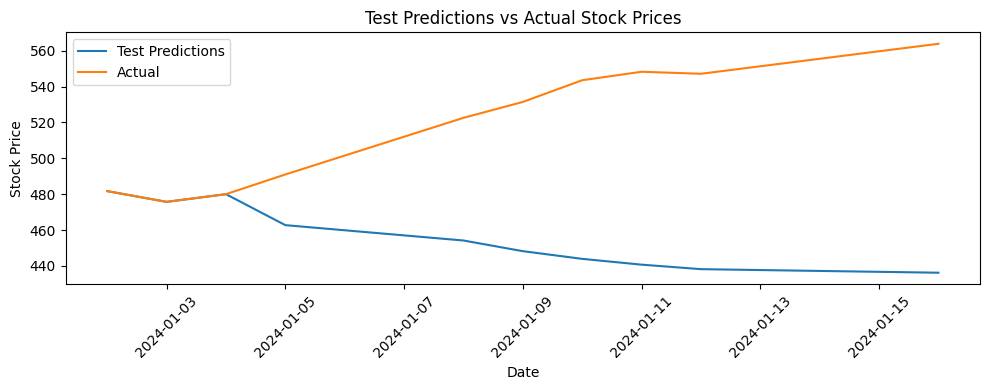

In [249]:
model = load_model('trained_models/baseline.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', ['Close'], 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)


loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 10
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(values)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df_all)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Z-score scaling

In [253]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()

test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

# Apply z-score normalization
train_df['Close'] = (train_df['Close'] - train_mean) / train_std
test_df['Close'] = (test_df['Close'] - test_mean) / test_std

## preprocessing

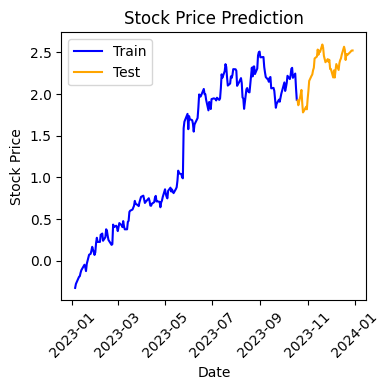

In [255]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29',  ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [257]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'zscore_.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 2.87462, saving model to trained_models\zscore_.keras

Epoch 2: val_loss improved from 2.87462 to 0.26544, saving model to trained_models\zscore_.keras

Epoch 3: val_loss improved from 0.26544 to 0.19629, saving model to trained_models\zscore_.keras

Epoch 4: val_loss improved from 0.19629 to 0.11902, saving model to trained_models\zscore_.keras

Epoch 5: val_loss did not improve from 0.11902

Epoch 6: val_loss improved from 0.11902 to 0.02405, saving model to trained_models\zscore_.keras

Epoch 7: val_loss improved from 0.02405 to 0.01127, saving model to trained_models\zscore_.keras

Epoch 8: val_loss did not improve from 0.01127

Epoch 9: val_loss did not improve from 0.01127

Epoch 10: val_loss did not improve from 0.01127

Epoch 11: val_loss did not improve from 0.01127

Epoch 12: val_loss did not improve from 0.01127

Epoch 13: val_loss did not improve from 0.01127

Epoch 14: val_loss did not improve from 0.01127

Epoch 15: val_loss did not

## plotting

2/2 [==============================] - 0s 2ms/step


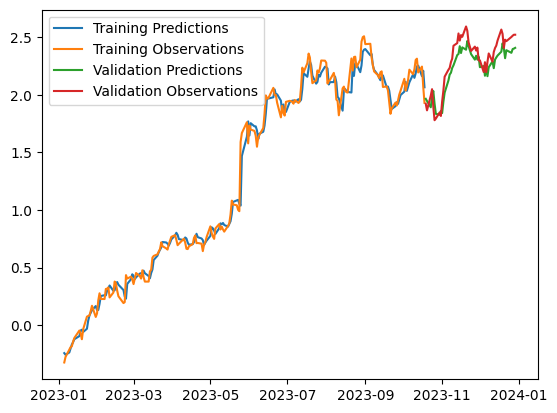

In [258]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

1/1 [==============================] - 1s 698ms/step - loss: 0.0405 - mean_absolute_error: 0.1820
Test Loss: 0.04051936790347099
Test Mean Absolute Error: 0.1820482462644577
1/1 [==============================] - 0s 14ms/step


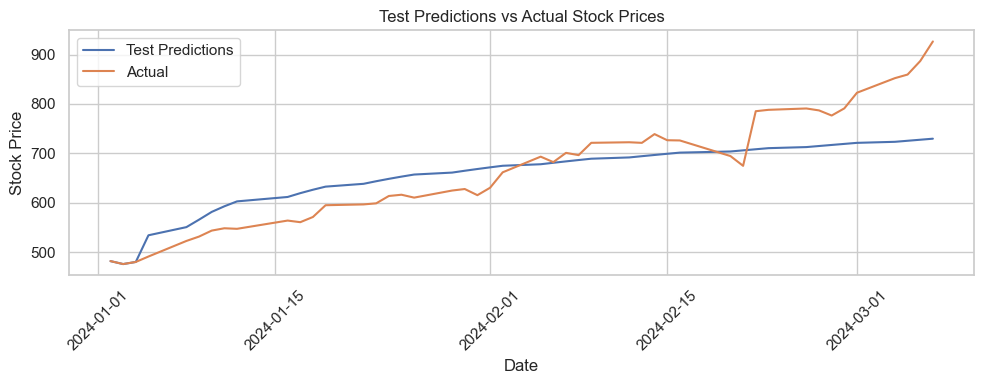

In [335]:
model = load_model('trained_models/zscore.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', ['Close'], 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

values = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Returns 

In [354]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

df_ret_train = train_df
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)


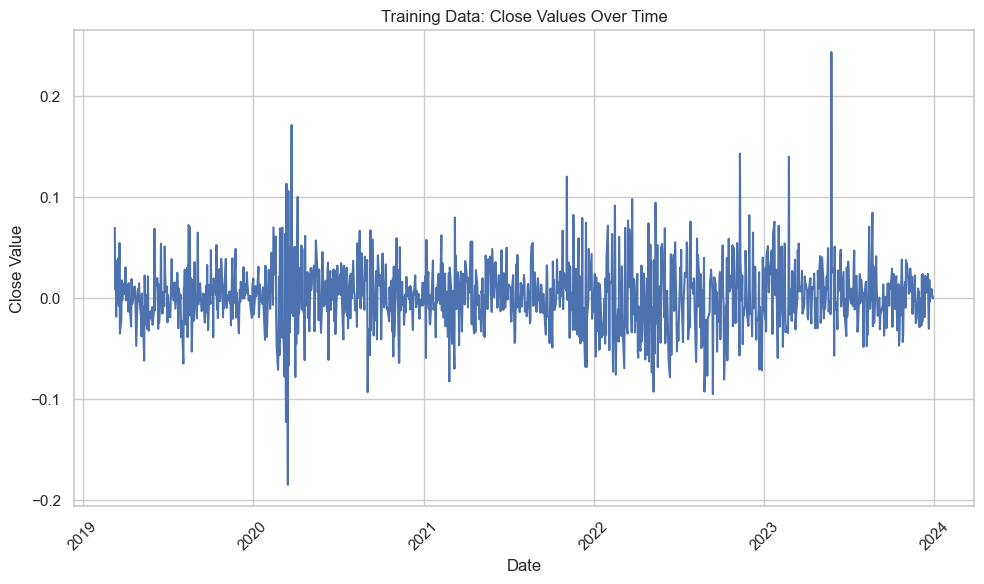

In [351]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


    Target Date  Return-3  Return-2  Return-1    Target
0    2023-01-05  0.000753 -0.020460  0.030318 -0.032816
1    2023-01-06 -0.020460  0.030318 -0.032816  0.041640
2    2023-01-09  0.030318 -0.032816  0.041640  0.051753
3    2023-01-10 -0.032816  0.041640  0.051753  0.017981
4    2023-01-11  0.041640  0.051753  0.017981  0.005783
..          ...       ...       ...       ...       ...
243  2023-12-22 -0.009445 -0.030098  0.018270 -0.003266
244  2023-12-26 -0.030098  0.018270 -0.003266  0.009195
245  2023-12-27  0.018270 -0.003266  0.009195  0.002800
246  2023-12-28 -0.003266  0.009195  0.002800  0.002125
247  2023-12-29  0.009195  0.002800  0.002125  0.000000

[248 rows x 5 columns]


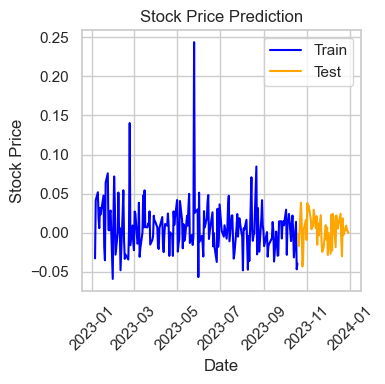

In [352]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', ['Return'], 'Return', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

print(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Training

In [344]:
model = Sequential([
    layers.Input((3, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[checkpoint], verbose=0)


In [358]:
train_df.iloc[0]

Return    0.069703
Name: 2019-03-11 00:00:00, dtype: float64

7/7 [==============================] - 0s 834us/step
[0.0043799  0.00457372 0.00430957 0.00419306 0.00379923 0.00420012
 0.00426868 0.00425463 0.00378986 0.00424889 0.00449773 0.0044013
 0.00349904 0.00346259 0.00417618 0.00432463 0.0042694  0.00449152
 0.00450731 0.00436596 0.00345036 0.00416701 0.00438943 0.00436782
 0.00426571 0.00423933 0.00472683 0.00453637 0.00435632 0.00421303
 0.00438219 0.00493846 0.00512689 0.00478791 0.00320847 0.0035832
 0.00383329 0.00454295 0.00460077 0.00445865 0.0043363  0.00428458
 0.00444309 0.0043798  0.00445056 0.00453184 0.0047443  0.00435231
 0.00426278 0.00372714 0.00422961 0.00421711 0.00433085 0.00432317
 0.00428304 0.00432428 0.00442038 0.00460836 0.00438844 0.00432069
 0.00426947 0.00430224 0.00441628 0.00464667 0.00463312 0.00440038
 0.004364   0.00457015 0.00468666 0.00450609 0.00434696 0.00429156
 0.00428803 0.00441338 0.00455729 0.00461991 0.00464275 0.00444961
 0.00438616 0.00425761 0.00419235 0.00428415 0.00442781 0.00472635
 0.00437068

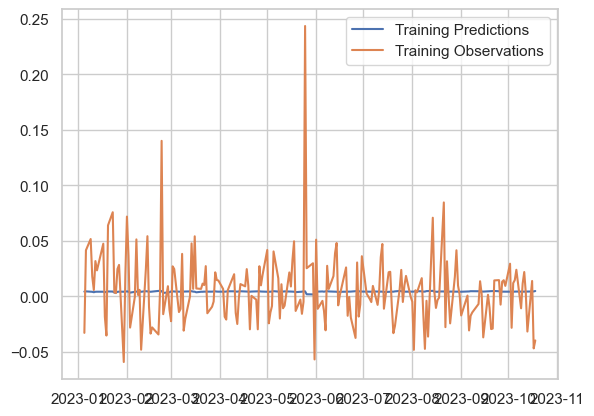

In [347]:
# Load the best model
return_model = load_model('trained_models/return.keras')
train_predictions = return_model.predict(X_train).flatten()


n = 4
s = 0

values = train_df[['Close']].iloc[0]
dates = train_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = 1+model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


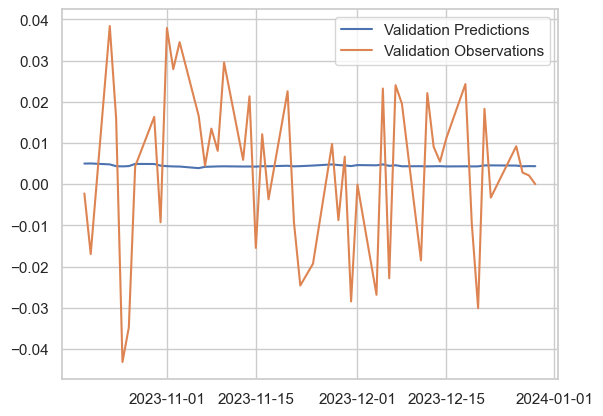

In [346]:
val_predictions = return_model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [208]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')


windowed_test_df = generate_windowed_dataset(test_df, '2024-01-06', '2024-01-15', 'Close',3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = 1+model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: in user code:

    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 10, 1), found shape=(None, 3, 1)


# News

In [7]:
import pandas as pd

file_path = 'news_retrieval/labelled_newscatcher_dataset.csv'

# Load the data and select specific columns
df = pd.read_csv(file_path, sep=';')

# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Select specific columns
df = df[['published_date', 'title']]

# Filter rows containing the word 'AI' in the 'title' column
df['contains_AI'] = df['title'].str.contains('AI', case=True)

# Create a new DataFrame with counts of AI articles published each day
daily_AI_counts = df.groupby(df['published_date'].dt.date)['contains_AI'].sum().reset_index()
daily_AI_counts.columns = ['published_date', 'AI_articles_count']

# Sort the new DataFrame by 'published_date'
daily_AI_counts = daily_AI_counts.sort_values(by='published_date')

print(daily_AI_counts)


    published_date  AI_articles_count
0       2012-09-16                  0
1       2015-10-23                  0
2       2016-09-23                  0
3       2016-12-08                  0
4       2016-12-22                  0
..             ...                ...
258     2020-08-14                 16
259     2020-08-15                 17
260     2020-08-16                  6
261     2020-08-17                 32
262     2020-08-18                  3

[263 rows x 2 columns]


# Multivariate LSTM

## data preprocessing

In [45]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close', 'Volume']]
test_df.index = test_df.pop('Date')


# train_means = train_df.mean()
# train_stds = train_df.std()

# test_means = test_df.mean()
# test_stds = test_df.std()

# for col in train_df.columns:
#     train_df[col] = (train_df[col] - train_means[col]) / train_stds[col]
#     test_df[col] = (test_df[col] - test_means[col]) / test_stds[col]


# feature_list = train_df.columns.to_list()
# n_features = len(feature_list)
# window_size = 3

# print(feature_list)
# print(train_df.head())
# print(test_df.head())

In [78]:
# Read the data and preprocess
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

def predict_future_values(train_df, feature_columns, future_days):
    future_df = pd.DataFrame(index=pd.bdate_range(start=train_df.index[-1], periods=future_days))

    for feature_column in feature_columns:
        split = int(len(train_df) * 0.8)
        train_data = train_df.iloc[:split]

        X_train = np.arange(len(train_data)).reshape(-1, 1)
        y_train = train_data[feature_column].values

        model = LinearRegression()
        model.fit(X_train, y_train)

        X_future = np.arange(len(train_data), len(train_data) + future_days).reshape(-1, 1)
        y_future_pred = model.predict(X_future)

        future_df[f'Predicted_{feature_column}'] = y_future_pred

    return future_df

future_features = ['Volume']
future_days = 50
future_df = predict_future_values(train_df, future_features, future_days)
print(future_df)


            Predicted_Volume
2023-12-29      4.884346e+07
2024-01-01      4.885145e+07
2024-01-02      4.885943e+07
2024-01-03      4.886742e+07
2024-01-04      4.887540e+07
2024-01-05      4.888338e+07
2024-01-08      4.889137e+07
2024-01-09      4.889935e+07
2024-01-10      4.890734e+07
2024-01-11      4.891532e+07
2024-01-12      4.892331e+07
2024-01-15      4.893129e+07
2024-01-16      4.893928e+07
2024-01-17      4.894726e+07
2024-01-18      4.895524e+07
2024-01-19      4.896323e+07
2024-01-22      4.897121e+07
2024-01-23      4.897920e+07
2024-01-24      4.898718e+07
2024-01-25      4.899517e+07
2024-01-26      4.900315e+07
2024-01-29      4.901114e+07
2024-01-30      4.901912e+07
2024-01-31      4.902710e+07
2024-02-01      4.903509e+07
2024-02-02      4.904307e+07
2024-02-05      4.905106e+07
2024-02-06      4.905904e+07
2024-02-07      4.906703e+07
2024-02-08      4.907501e+07
2024-02-09      4.908300e+07
2024-02-12      4.909098e+07
2024-02-13      4.909897e+07
2024-02-14    

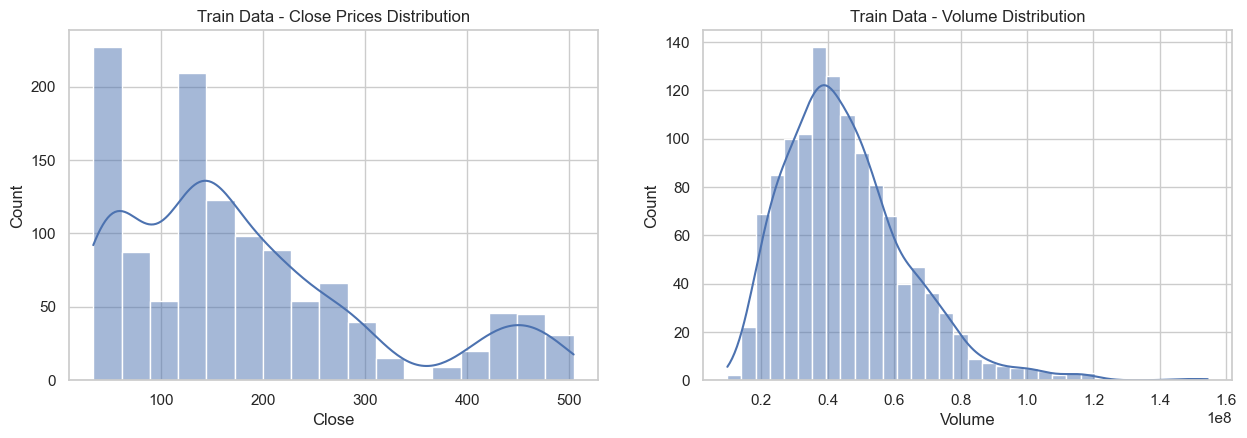

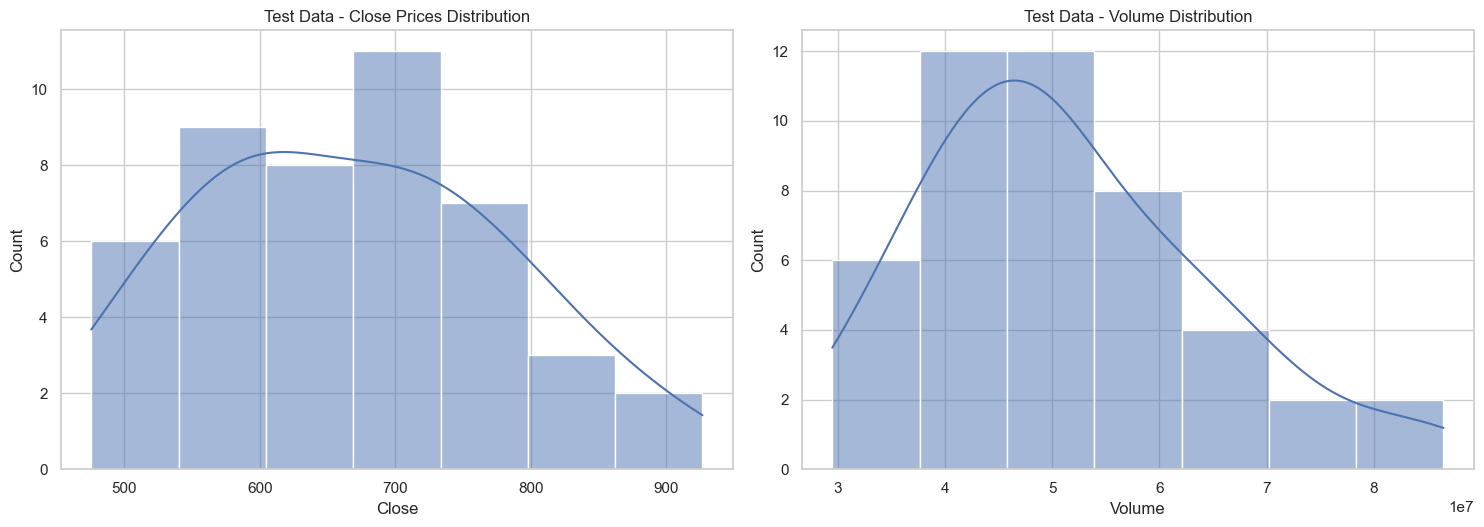

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have train_df and test_df loaded and processed

# Set the style of seaborn for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting for train_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 1)
sns.histplot(train_df['Close'], kde=True)
plt.title('Train Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(train_df['Volume'], kde=True)
plt.title('Train Data - Volume Distribution')

# Plotting for test_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 3)
sns.histplot(test_df['Close'], kde=True)
plt.title('Test Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 4)
sns.histplot(test_df['Volume'], kde=True)
plt.title('Test Data - Volume Distribution')

plt.tight_layout()
plt.show()


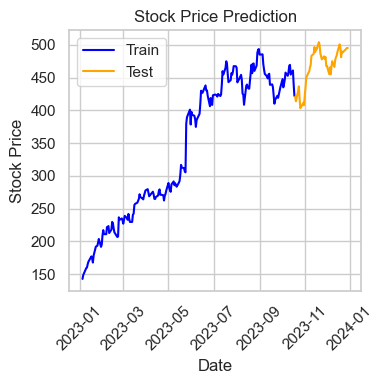

In [80]:
feature_list = ['Close', 'Volume']

windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', feature_list, 'Close', window_size)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [81]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3*n_features, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'multivariate.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 215052.09375, saving model to trained_models\multivariate.keras

Epoch 2: val_loss improved from 215052.09375 to 208991.73438, saving model to trained_models\multivariate.keras

Epoch 3: val_loss improved from 208991.73438 to 201000.43750, saving model to trained_models\multivariate.keras

Epoch 4: val_loss improved from 201000.43750 to 192503.12500, saving model to trained_models\multivariate.keras

Epoch 5: val_loss improved from 192503.12500 to 184472.81250, saving model to trained_models\multivariate.keras

Epoch 6: val_loss improved from 184472.81250 to 176865.71875, saving model to trained_models\multivariate.keras

Epoch 7: val_loss improved from 176865.71875 to 169572.59375, saving model to trained_models\multivariate.keras

Epoch 8: val_loss improved from 169572.59375 to 162449.40625, saving model to trained_models\multivariate.keras

Epoch 9: val_loss improved from 162449.40625 to 155252.76562, saving model to trained_models\multivariat

KeyboardInterrupt: 

## plotting

2/2 [==============================] - 0s 3ms/step


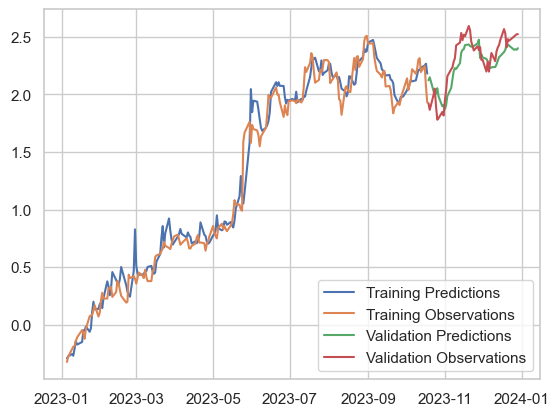

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

In [16]:
print(feature_list)

['Close', 'Volume']


In [330]:
model = load_model('trained_models/multivariate.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', feature_list, 'Close', window_size)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

print(X_test)

loss, mae = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 0

values = test_df['Close'].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)


pred_measure = model.predict(X_test).flatten()[0]
measures.append(pred_measure)
values.append(pred_measure)


print("values", values)

# for date in range(n-3):
#     x = np.array(measures, dtype=float).reshape((1,n_features*3,1))
#     print(x)
#     pred_measure = model.predict(x).flatten()[0]
#     print(pred_measure)
#     measures.append(pred_measure)
#     values.append(pred_measure)

values = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

[[[-1.5974165 ]
  [-1.6491034 ]
  [-1.6120855 ]
  [-0.75832516]
  [-1.4350181 ]
  [-1.5425678 ]]

 [[-1.6491034 ]
  [-1.6120855 ]
  [-1.5172542 ]
  [-1.4350181 ]
  [-1.5425678 ]
  [-0.7335065 ]]

 [[-1.6120855 ]
  [-1.5172542 ]
  [-1.2449268 ]
  [-1.5425678 ]
  [-0.7335065 ]
  [ 0.9735557 ]]

 [[-1.5172542 ]
  [-1.2449268 ]
  [-1.1683887 ]
  [-0.7335065 ]
  [ 0.9735557 ]
  [ 1.9515468 ]]

 [[-1.2449268 ]
  [-1.1683887 ]
  [-1.0639795 ]
  [ 0.9735557 ]
  [ 1.9515468 ]
  [ 0.15939435]]

 [[-1.1683887 ]
  [-1.0639795 ]
  [-1.0232515 ]
  [ 1.9515468 ]
  [ 0.15939435]
  [ 0.63092554]]

 [[-1.0639795 ]
  [-1.0232515 ]
  [-1.0329158 ]
  [ 0.15939435]
  [ 0.63092554]
  [-1.1984923 ]]]
1/1 [==============================] - 0s 400ms/step
values [-1.5974165627859744, -1.6491034392458697, -1.6120854929426387]


ValueError: cannot reshape array of size 3 into shape (1,6,1)

# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing
